In [72]:
import rasterio
import os
import numpy as np
from shapely.geometry import box
from rasterio.windows import from_bounds, bounds
import matplotlib.pyplot as plt
from rasterio.warp import calculate_default_transform, reproject, Resampling
from matplotlib import pyplot

In [106]:
import rasterio
from rasterio.windows import from_bounds, bounds
from shapely.geometry import box

def reproyectar_raster_PP(path_slope = 'Slope_SRTM_Zone_WGS84.tif', path_pp1 = 'output/2024_09_13.tif', path_name_output = 'output/output_pp.tif'):

    with rasterio.open(path_slope) as src1, rasterio.open(path_pp1) as src2:
        ext1 = box(*src1.bounds)
        ext2 = box(*src2.bounds)
        print(f'ext1: {ext1}\next2: {ext2}')
        
        # Intersection devuelve la geometría que se comparte entre las geometrías de entrada
        intersection = ext1.intersection(ext2)
        print(f'intersection: {intersection}')
        
        window = from_bounds(*intersection.bounds, src1.transform)
        print(f'Ventanas: {window}')
        
        # Leer los datos de la ventana de intersección del archivo de precipitación
        data_pp = src2.read(1, window=window)
        print(f'Tipo de dato {type(data_pp)}\nDatos: {data_pp}')
        print('bounds:', bounds(window, src1.transform))
        
        left, bottom, right, top = bounds(window, src1.transform)
        new_transform = src1.window_transform(window)
        height = window.height
        width = window.width
        print(f'La ventana es: {width} X {height}, Teniendo: {window}')
        
        kwargs = src1.meta.copy()
        print(kwargs)
        kwargs.update({
            'width': width,
            'height': height,
            'transform': new_transform,
            'crs': src2.crs  # Asegúrate de que el CRS sea el mismo que el de src2
        })
        print(f'kwargs: {kwargs}')
        print(window)
        
        # Creación del nuevo archivo TIFF con los datos de precipitación
        with rasterio.open(path_name_output, 'w', **kwargs) as dst:
            dst.write(data_pp, 1)

In [80]:
"""import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.windows import from_bounds, bounds
from rasterio.warp import calculate_default_transform
from shapely.geometry import box

path_slope = 'Slope_SRTM_Zone_WGS84.tif'
path_pp1 = 'output/2024_09_10.tif'
path_output = 'output/'

with rasterio.open(path_slope) as src1, rasterio.open(path_pp1) as src2:
    ext1 = box(*src1.bounds)
    ext2 = box(*src2.bounds)
    print(f'ext1: {ext1}\next2: {ext2}')
    
    # Intersection devuelve la geometría que se comparte entre las geometrías de entrada
    intersection = ext1.intersection(ext2)
    print(f'intersection: {intersection}')
    
    window = from_bounds(*intersection.bounds, src1.transform)
    print(f'Ventanas: {window}')
    
    # Leer los datos de la ventana de intersección del archivo de precipitación
    data_pp = src2.read(1, window=window)
    print(f'Tipo de dato {type(data_pp)}\nDatos: {data_pp}')
    print('bounds:', bounds(window, src1.transform))
    
    left, bottom, right, top = bounds(window, src1.transform)
    new_transform, width, height = calculate_default_transform(src1.crs, src1.crs, data_pp.shape[1], data_pp.shape[0],
                                                               left, bottom, right, top)
    height = window.height
    width = window.width
    print(f'La ventana es: {width} X {height}, Teniendo: {window}')
    
    kwargs = src1.meta.copy()
    print(kwargs)
    kwargs.update({
        'width': width,
        'height': height,
        'transform': new_transform,
        'crs': src2.crs  # Asegúrate de que el CRS sea el mismo que el de src2
    })
    print(f'kwargs: {kwargs}')
    print(window)
    
    # Creación del nuevo archivo TIFF con los datos de precipitación
    with rasterio.open(path_output + 'output_pp.tif', 'w+', **kwargs) as dst:
        print('------------------------------------------\n', data_pp)
        reproject(
            source=data_pp,
            destination=rasterio.band(dst, 1),
            src_transform=src2.window_transform(window),
            src_crs=src2.crs,
            dst_crs=src2.crs,
            dst_transform=new_transform,
            resampling=Resampling.bilinear
        )"""

ext1: POLYGON ((-70.82414754 -41.065264796, -70.82414754 -37.936163569, -74.042230979 -37.936163569, -74.042230979 -41.065264796, -70.82414754 -41.065264796))
ext2: POLYGON ((-68.9459228515625 -36.313880920410156, -68.9459228515625 -48.062965393066406, -78.54290771484375 -48.062965393066406, -78.54290771484375 -36.313880920410156, -68.9459228515625 -36.313880920410156))
intersection: POLYGON ((-74.042230979 -41.065264796, -74.042230979 -37.936163569, -70.82414754 -37.936163569, -70.82414754 -41.065264796, -74.042230979 -41.065264796))
Ventanas: Window(col_off=0.0, row_off=0.0, width=11592.0, height=11262.0)
Tipo de dato <class 'numpy.ndarray'>
Datos: [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.23380588  0.22872874 ...  0.          0.
   0.        ]
 [ 0.          0.24050066  0.18175383 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.6890626   0.49410963 ... 33.14177    35.983006
   0.        ]
 [ 0.          0.83241224  0.6112833  

In [110]:
def reproyectar_raster_slope(path_slope = 'Slope_SRTM_Zone_WGS84.tif', path_pp = 'output/2024_09_11.tif', path_name_output = 'output/output.tif'):
    with rasterio.open(path_slope) as src1, rasterio.open(path_pp) as src2:
        ext1 = box(*src1.bounds)
        ext2 = box(*src2.bounds)
        print(f'ext1: {ext1}\next2: {ext2}')
        # intersection devuelve la geometria que se comparte entre las geometrias de entradas
        intersection = ext1.intersection(ext2)
        print(f'intersection: {intersection}')
        
        window = from_bounds(*intersection.bounds, src1.transform)
        print(f'Ventanas: {window}')
        data = src1.read(window=window)
        print(f'Tipo de dato {type(data)}\nDatos: {data}')
        print('bounds:', bounds(window, src1.transform))
        left, bottom, right, top = bounds(window, src1.transform)
        #calculate default transform: (source coor, target coor, width, height, left, bot,right, top)
        #print('src1.crs',src1.crs)
        #print('src2.crs',src2.crs)
        print('data.shape[1]', data.shape[1])
        print('data.shape[2]', data.shape[2])
        new_transform, width, height = calculate_default_transform(src1.crs, src1.crs, data.shape[2], data.shape[1],
                                                                left, bottom, right, top)
        height = window.height
        width = window.width
        #new_transform, width, height = calculate_default_transform(src1.crs, src1.crs, width, height,
        #                                                           left, bottom, right, top)
        print(f'La ventana es: {width} X {height}, Teniendo: {window}')
        kwargs = src1.meta.copy()
        print(kwargs)
        kwargs.update({
            'width': width,
            'height': height
        })
        print(f'kwargs: {kwargs}')
        print(window)
        # Creación del nuevo path
        with rasterio.open(path_name_output, 'w+', **kwargs) as dst:
            print('------------------------------------------\n',data)
            reproject(
                source=data,
                destination=rasterio.band(dst, 1),
                src_transform=src1.window_transform(window),
                window=window,
                src_crs=src1.crs,
                dst_crs=src2.crs,
                dst_transform=new_transform,
                resampling=Resampling.bilinear
            )

In [124]:
path_slope = 'output/output.tif'
path_rosetta = 'Soils/ROSETTA_MEAN/alpha_5-15cm.tif'
path_name_output = 'output/output_alpha.tif'
with rasterio.open(path_slope) as src1, rasterio.open(path_rosetta) as src2:
        ext1 = box(*src1.bounds)
        ext2 = box(*src2.bounds)
        print(f'ext1: {ext1}\next2: {ext2}')
        print(f'CRS1: {src1.crs}')
        print(f'CRS2: {src2.crs}')
        # Intersection devuelve la geometría que se comparte entre las geometrías de entrada
        intersection = ext1.intersection(ext2)
        print(f'intersection: {intersection}')
        
        window = from_bounds(*intersection.bounds, src1.transform)
        print(f'Ventanas: {window}')
        
        # Leer los datos de la ventana de intersección del archivo de precipitación
        data_pp = src2.read(1, window=window)
        print(f'Tipo de dato {type(data_pp)}\nDatos: {data_pp}')
        print('bounds:', bounds(window, src1.transform))
        
        left, bottom, right, top = bounds(window, src1.transform)
        new_transform = src1.window_transform(window)
        height = window.height
        width = window.width
        print(f'La ventana es: {width} X {height}, Teniendo: {window}')
        
        kwargs = src1.meta.copy()
        print(kwargs)
        kwargs.update({
            'width': width,
            'height': height,
            'transform': new_transform,
            'crs': src2.crs  # Asegúrate de que el CRS sea el mismo que el de src2
        })
        print(f'kwargs: {kwargs}')
        print(window)
        
        # Creación del nuevo archivo TIFF con los datos de precipitación
        with rasterio.open(path_name_output, 'w', **kwargs) as dst:
            dst.write(data_pp, 1)

ext1: POLYGON ((-70.82414754 -41.065264796, -70.82414754 -37.936163569, -74.042230979 -37.936163569, -74.042230979 -41.065264796, -70.82414754 -41.065264796))
ext2: POLYGON ((-66.104306662 -56.15887467999999, -66.104306662 -17.317874679999996, -75.995306662 -17.317874679999996, -75.995306662 -56.15887467999999, -66.104306662 -56.15887467999999))
CRS1: EPSG:4326
CRS2: EPSG:4326
intersection: POLYGON ((-74.042230979 -41.065264796, -74.042230979 -37.936163569, -70.82414754 -37.936163569, -70.82414754 -41.065264796, -74.042230979 -41.065264796))
Ventanas: Window(col_off=0.0, row_off=0.0, width=11592.0, height=11262.0)
Tipo de dato <class 'numpy.ndarray'>
Datos: [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
bounds: (-74.042230979, -41.065264796, -70.82414754, -37.936163569)
La ventana es: 11592.0 X 11262.0, Teniendo: Window(col_off=0.0, row_off=0.

In [130]:
# chatgpt funciones.
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np

def intersect_tiffs(tiff1_path, tiff2_path, output_path):
    """
    Encuentra la intersección entre dos archivos TIFF y crea uno nuevo con los datos del segundo TIFF
    recortados al área de intersección del primero.
    
    Args:
        tiff1_path (str): Ruta al primer archivo TIFF (se usará su extensión)
        tiff2_path (str): Ruta al segundo archivo TIFF (se usarán sus datos)
        output_path (str): Ruta donde se guardará el nuevo TIFF
    """
    
    # Abrir ambos archivos TIFF
    with rasterio.open(tiff1_path) as src1:
        with rasterio.open(tiff2_path) as src2:
            # Obtener los bounds (límites) del primer TIFF
            bounds = src1.bounds
            
            # Verificar si los sistemas de coordenadas son diferentes
            if src1.crs != src2.crs:
                print('CRS diferentes')
                # Calcular la transformación necesaria
                transform, width, height = calculate_default_transform(
                    src2.crs, src1.crs, src2.width, src2.height, *src2.bounds)
                
                # Crear un array temporal para reproyectar
                temp_data = np.zeros((height, width), dtype=src2.dtypes[0])
                
                # Reproyectar los datos del segundo TIFF al CR.S del primero
                reproject(
                    source=rasterio.band(src2, 1),
                    destination=temp_data,
                    src_transform=src2.transform,
                    src_crs=src2.crs,
                    dst_transform=transform,
                    dst_crs=src1.crs,
                    resampling=Resampling.nearest
                )
                
                # Actualizar los metadatos para el archivo reproyectado
                profile = src2.profile.copy()
                profile.update({
                    'crs': src1.crs,
                    'transform': transform,
                    'width': width,
                    'height': height
                })
                
                # Crear un dataset temporal con los datos reproyectados
                with rasterio.MemoryFile() as memfile:
                    with memfile.open(**profile) as temp_dataset:
                        temp_dataset.write(temp_data, 1)
                        # Realizar el recorte usando los bounds del primer TIFF
                        out_image, out_transform = mask(temp_dataset, 
                                                      [{'type': 'Polygon', 
                                                        'coordinates': [[
                                                            [bounds.left, bounds.bottom],
                                                            [bounds.left, bounds.top],
                                                            [bounds.right, bounds.top],
                                                            [bounds.right, bounds.bottom],
                                                            [bounds.left, bounds.bottom]
                                                        ]]}],
                                                      crop=True)
            else:
                # Si tienen el mismo CRS, hacer el recorte directamente
                print('CRS iguales')
                out_image, out_transform = mask(src2, 
                                              [{'type': 'Polygon', 
                                                'coordinates': [[
                                                    [bounds.left, bounds.bottom],
                                                    [bounds.left, bounds.top],
                                                    [bounds.right, bounds.top],
                                                    [bounds.right, bounds.bottom],
                                                    [bounds.left, bounds.bottom]
                                                ]]}],
                                              crop=True)
            
            # Preparar el perfil para el archivo de salida
            out_profile = src2.profile.copy()
            out_profile.update({
                'height': out_image.shape[1],
                'width': out_image.shape[2],
                'transform': out_transform
            })
            
            # Guardar el resultado
            with rasterio.open(output_path, 'w', **out_profile) as dest:
                dest.write(out_image)

if __name__ == "__main__":
    path_slope = 'output/output.tif'
    path_rosetta = 'Soils/PIRange-001/PIRange_Bulkd.30-60cm.tif'
    path_name_output = 'output/output_bulkd.tif'
    
    intersect_tiffs(path_slope, path_rosetta, path_name_output)

CRS iguales


In [112]:
reproyectar_raster_slope()
#reproyectar_raster_PP()

ext1: POLYGON ((-70.82414754 -41.065264796, -70.82414754 -37.936163569, -74.042230979 -37.936163569, -74.042230979 -41.065264796, -70.82414754 -41.065264796))
ext2: POLYGON ((-68.9459228515625 -36.313880920410156, -68.9459228515625 -48.062965393066406, -78.54290771484375 -48.062965393066406, -78.54290771484375 -36.313880920410156, -68.9459228515625 -36.313880920410156))
intersection: POLYGON ((-74.042230979 -41.065264796, -74.042230979 -37.936163569, -70.82414754 -37.936163569, -70.82414754 -41.065264796, -74.042230979 -41.065264796))
Ventanas: Window(col_off=0.0, row_off=0.0, width=11592.0, height=11262.0)
Tipo de dato <class 'numpy.ndarray'>
Datos: [[[-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  ...
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]]]
bounds: (-74.042230979, -41.06526

# ----------------------------------------

In [131]:
import rasterio
from rasterio.windows import Window
from rasterio.plot import show
output_tif_path = 'output/output_alpha.tif'

with rasterio.open(output_tif_path) as src:
    meta = src.meta
    print('Metadatos: ',meta)
    data = src.read(1)
    print('Datos: ',data)
    width = meta['width']
    height = meta['height']
    print(f'Width: {width}\nHeight: {height}')
    window = src.window(*src.bounds)
    print('Ventana: ',window)
    data_window = src.read(1, window=window)
    print('Datos de la ventana: ',data_window)
    
    #lon, lat = -73.219497,-37.7517708

    lon,lat = -73.5688,-40.2737
    row, col = src.index(lon, lat)
    print(f'Row: {row}\nCol: {col}')
    value = data_window[row,col]
    print(f'Valor en ({lon},{lat}): {value}')
    print(np.unique(data_window))
    
    

Metadatos:  {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 3219, 'height': 3130, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0010000000000000005, 0.0, -74.042306662,
       0.0, -0.0009999999999999998, -37.93587467999999)}
Datos:  [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Width: 3219
Height: 3130
Ventana:  Window(col_off=0.0, row_off=0.0, width=3219.0, height=3130.0000000000073)
Datos de la ventana:  [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Row: 2337
Col: 473
Valor en (-73.5688,-40.2737): 0.010999999940395355
[0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012 0.013 0.014
 0.015 0.016 0.017 0.018 0.019 0.02  0.021 0.022 0.023 0.024 0.027 0.028
   

Metadatos:  {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 11592, 'height': 11262, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002776124429779156, 0.0, -74.042230979,
       0.0, -0.0002778459622624755, -37.936163569)}
Datos:  [[-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 ...
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]]
Width: 11592
Height: 11262
Ventana:  Window(col_off=0.0, row_off=0.0, width=11592.0, height=11262.0)
Datos de la ventana:  [[-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 ...
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]]


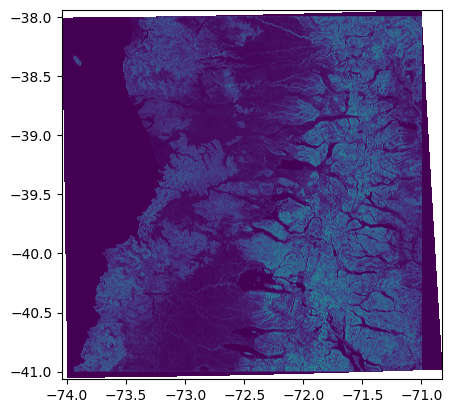

Row: 8413
Col: 1705
Valor en (-73.5688,-40.2737): 23.16396713256836
[-9.999000e+03 -5.820184e-07 -5.638303e-07 ...  8.886437e+01  8.887114e+01
  8.887433e+01]


In [134]:
import rasterio
from rasterio.windows import Window
from rasterio.plot import show, show_hist
output_tif_path = 'output/output.tif'

with rasterio.open(output_tif_path) as src:
    meta = src.meta
    print('Metadatos: ',meta)
    data = src.read(1)
    print('Datos: ',data)
    width = meta['width']
    height = meta['height']
    print(f'Width: {width}\nHeight: {height}')
    window = src.window(*src.bounds)
    print('Ventana: ',window)
    data_window = src.read(1, window=window)
    print('Datos de la ventana: ',data_window)
    show(src, transform=src.transform, cmap='viridis')
    #lon, lat = -73.219497,-37.7517708

    lon,lat = -73.5688,-40.2737
    row, col = src.index(lon, lat)
    print(f'Row: {row}\nCol: {col}')
    value = data_window[row,col]
    print(f'Valor en ({lon},{lat}): {value}')    
    print(np.unique(data_window))

In [2]:
import rasterio
import pandas as pd
import numpy as np
from tqdm import tqdm

def tif_to_dataframe(tif_path):
    with rasterio.open(tif_path) as src:
        data = src.read(1)
        
        height, width = data.shape
        
        latitudes = []
        longitudes = []
        values = []
        
        # Iterar sobre cada píxel del raster
        for row in tqdm(range(height)):
            for col in range(width):
                
                lon, lat = src.xy(row, col)
                
                value = data[row, col]
                
                latitudes.append(lat)
                longitudes.append(lon)
                values.append(value)
        
        df = pd.DataFrame({
            'Latitud': latitudes,
            'Longitud': longitudes,
            'Value': values
        })
        
        return df

tif_path = 'output/output.tif'
df = tif_to_dataframe(tif_path)
print(df.head())

#obtención de dataframe valores slope, latitud y longitud
# a partir de estas latitudes y longitudes se obtendrán los valores de los otros tif

100%|██████████| 11262/11262 [54:58<00:00,  3.41it/s] 


    Latitude  Longitude   Value
0 -37.936302 -74.042092 -9999.0
1 -37.936302 -74.041815 -9999.0
2 -37.936302 -74.041537 -9999.0
3 -37.936302 -74.041259 -9999.0
4 -37.936302 -74.040982 -9999.0


In [7]:
import numpy as np
df = pd.read_csv('lat_lon_slope.csv', index=False)
df.Value.replace("-9999", np.nan, inplace=True)

C:\Users\ivo\AppData\Local\Temp\ipykernel_24876\731091974.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.Value.replace("-9999", np.nan, inplace=True)


,Latitude,Longitude,Value
0,-37.936302,-74.042092,-9999.0
1,-37.936302,-74.041815,-9999.0
2,-37.936302,-74.041537,-9999.0
3,-37.936302,-74.041259,-9999.0
4,-37.936302,-74.040982,-9999.0
...,...,...,...
130549099,-41.065126,-70.825397,-9999.0
130549100,-41.065126,-70.825119,-9999.0
130549101,-41.065126,-70.824842,-9999.0
130549102,-41.065126,-70.824564,-9999.0


In [10]:
df.loc[df.Value == -9999, 'Value'] = np.nan
df.isna().sum()

Latitude           0
Longitude          0
Value        7208393
dtype: int64

In [3]:
import pandas as pd
def values_from_df(df: pd.DataFrame, tif_path: list) -> pd.DataFrame:
    
    for path in tif_path:
        with rasterio.open(path) as src:
            data = src.read(1)
            height, width = data.shape
            values = []
            for index, row in df.iterrows():
                lon = row['Longitud']
                lat = row['Latitud']
                row, col = src.index(lon, lat)
                value = data[row, col]
                values.append(value)
            df[path] = values
                

(130549104, 3)


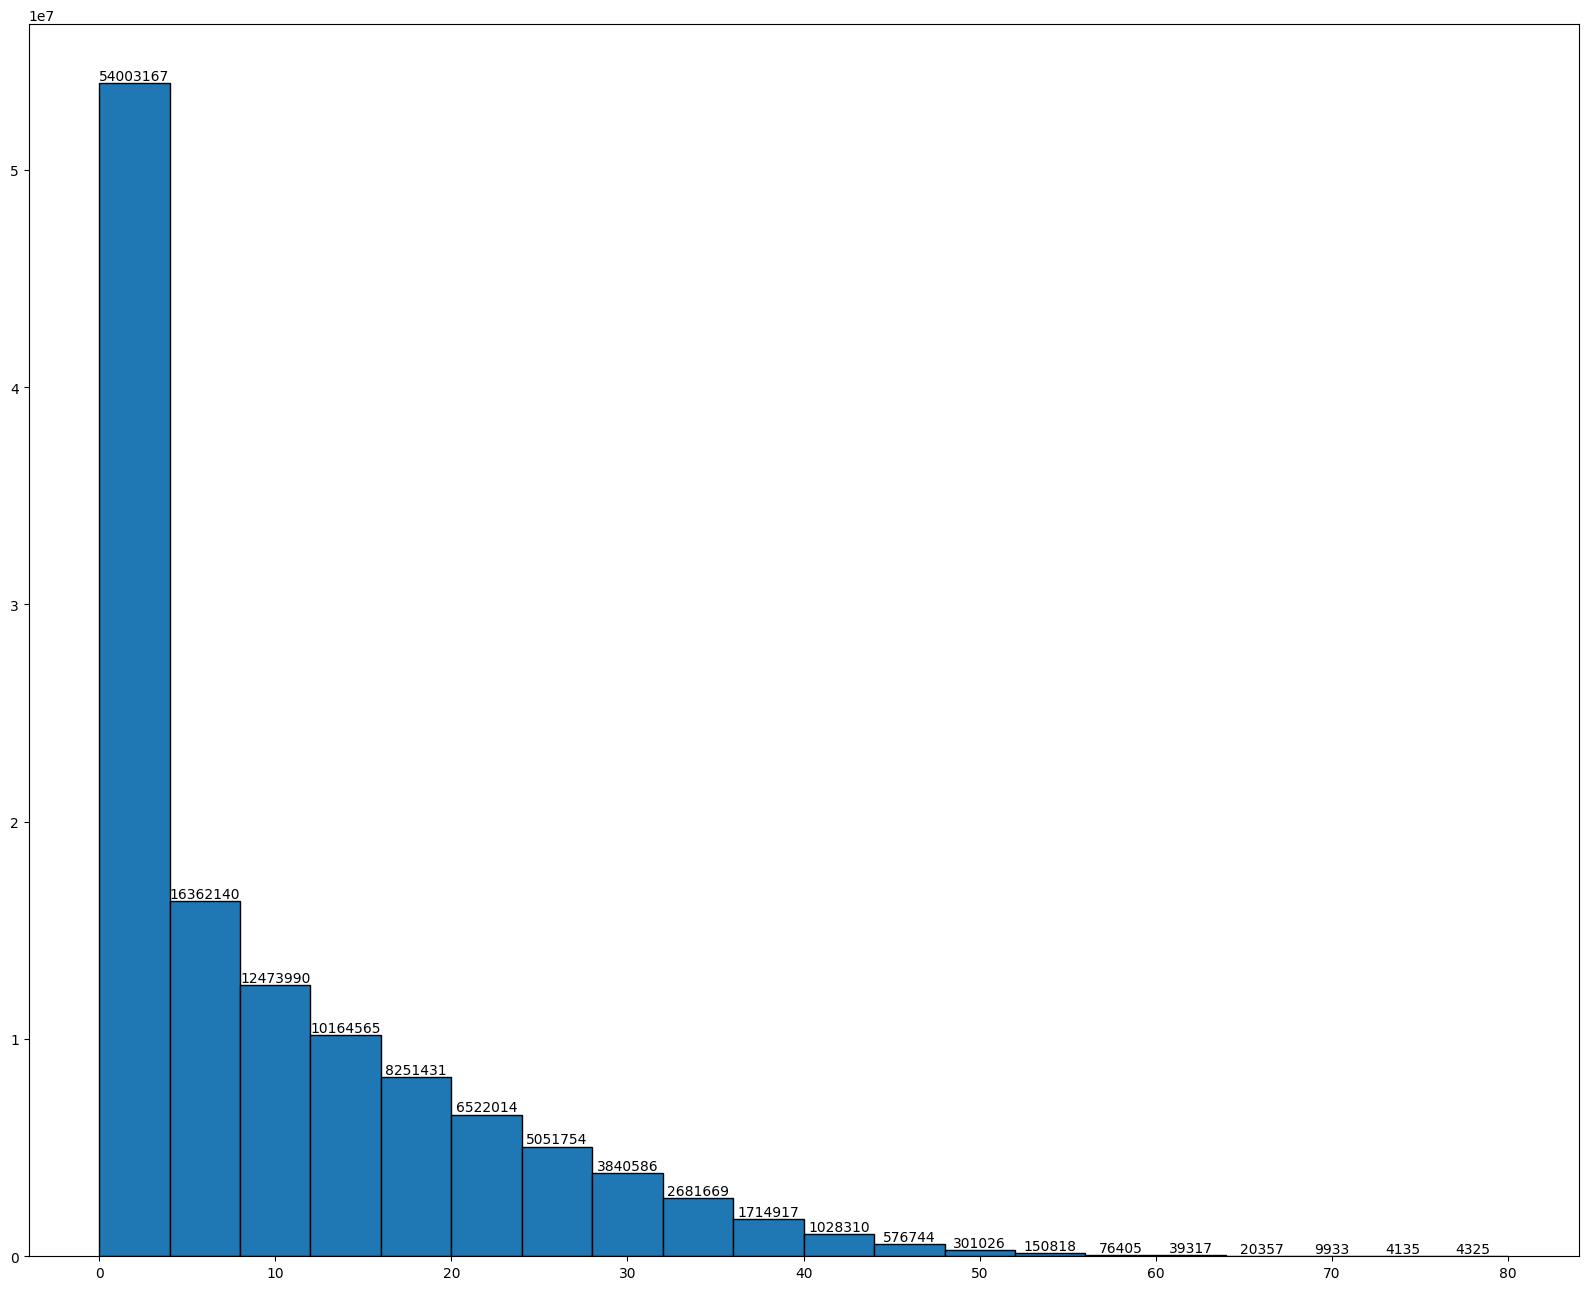

In [11]:
import matplotlib.pyplot as plt

df_filterded = df[(df['Value'] >= 0) & (df['Value'] <= 80)]
ax = df_filterded['Value'].hist(bins=20, edgecolor='black', grid=False, figsize=(20, 16))

for patch in ax.patches:
    bin_value = patch.get_height()
    if bin_value > 0:  
        plt.annotate(f'{bin_value:.0f}', 
                     (patch.get_x() + patch.get_width() / 2, patch.get_height()), 
                     ha='center', va='bottom')

print(df.shape)

In [4]:
import numpy as np

from osgeo import gdal, gdalconst, osr
from netCDF4 import Dataset

In [86]:
def nc_to_tif(nc_file_path = 'WRFProno_20240908181246.nc'):
    # convertir archivo nc a tif
    nc_file = Dataset(nc_file_path, 'r')

    lon = nc_file.variables['XLONG'][:]
    lat = nc_file.variables['XLAT'][:]
    lon_min, lon_max = lon.min(), lon.max()
    lat_min, lat_max = lat.min(), lat.max()
    print(f'Latitud {lat_min} {lat_max}')
    print(f'Longitud {lon_min} {lon_max}')

    cols, rows = len(lon[0]), len(lat[0])
    rainnc = nc_file.variables['RAINNC']
    cols, rows = np.size(rainnc[0], 1), np.size(rainnc[0], 0)
    dx = (lon_max - lon_min) / cols
    dy = (lat_max - lat_min) / rows
    transform = [lon_min, dx, 0, lat_min, 0, dy]

    
    string_date = []

    for time_index, timestamp_bytes in enumerate(nc_file.variables['Times']):
        timestamp_str = b''.join(timestamp_bytes).decode('utf-8')
        string_date.append(timestamp_str[:10])

    fec_uni = set(string_date)
    print(fec_uni)
    for ind in fec_uni:
        ind_fec = [indice for indice, valor in enumerate(string_date) if valor == ind]
        print(max(ind_fec), min(ind_fec))
        if min(ind_fec) > 0:
            data1 = rainnc[max(ind_fec), :, :] - rainnc[min(ind_fec)-1, :, :]
        else:
            data1 = rainnc[max(ind_fec), :, :]
        print(data1.shape)
        
        output_tif_path = fr'output/{ind[:4]}_{ind[5:7]}_{ind[8:10]}.tif'    
        driver = gdal.GetDriverByName('GTiff')
        print(f'rows, cols: {output_tif_path} {rows} {cols}')
        output_tiff = driver.Create(output_tif_path, cols,rows,  1, gdal.GDT_Float32)

        output_tiff.SetGeoTransform(transform)
        srs = osr.SpatialReference()
        srs.ImportFromEPSG(4326)
        output_tiff.SetProjection(srs.ExportToWkt())
        print('-'*20,np.flipud(data1))
        #data = np.flipud(data1) # No entiendo
        data = data1
        output_tiff.GetRasterBand(1).WriteArray(data)
        output_tiff = None
    nc_file.close()
    

nc_to_tif()

Latitud -48.062965393066406 -36.313880920410156
Longitud -78.54290771484375 -68.9459228515625
{'2024-09-10', '2024-09-09', '2024-09-11', '2024-09-12', '2024-09-13', '2024-09-08'}
59 36
(213, 120)
rows, cols: output/2024_09_10.tif 213 120
-------------------- [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.83241224  0.6112833  ... 33.386032   36.16939
   0.        ]
 [ 0.          0.6890626   0.49410963 ... 33.14177    35.983006
   0.        ]
 ...
 [ 0.          0.24050066  0.18175383 ...  0.          0.
   0.        ]
 [ 0.          0.23380588  0.22872874 ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
35 12
(213, 120)
rows, cols: output/2024_09_09.tif 213 120
-------------------- [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.9396749e+00 2.0101240e+00 ... 1.9958555e+00
  2.4097159e+00 0.0000000e+00]
 [0.0000000e+00 2.24

In [ ]:
import rasterio
import pandas as pd
import numpy as np
from tqdm import tqdm

def tif_to_dataframe_with_window(reference_tif_path: str, tif_paths: list) -> pd.DataFrame:

    # Abrir el TIF de referencia para obtener las coordenadas
    with rasterio.open(reference_tif_path) as ref_src:
        ref_array = ref_src.read(1)
        ref_transform = ref_src.transform
    
        mask = ref_array != ref_src.nodatavals[0]
        rows, cols = np.where(mask)
        print(f'Filas: {rows}\nColumnas: {cols}')

        # Obtener coordenadas
        xs, ys = rasterio.transform.xy(ref_transform, rows, cols)
        longitudes = np.array(xs)
        latitudes = np.array(ys)
        print(f'Longitudes: {longitudes}\nLatitudes: {latitudes}')
    data = {'Latitude': latitudes, 'Longitude': longitudes}

    # Iterar sobre los TIFs y extraer los valores en las coordenadas
    for tif_path in tif_paths:
        values = []
        print("Comenzando a extraer valores de", tif_path)
        with rasterio.open(tif_path) as src:
            if src.crs != ref_src.crs:
                raise ValueError(f"El CRS de {tif_path} no coincide con el del TIF de referencia.")

            for val in tqdm(src.sample(zip(longitudes, latitudes))):
                values.append(val[0] if val else np.nan)

        tif_name = tif_path.split('/')[-1]
        data[tif_name] = values
 
    df = pd.DataFrame(data)
    return df

if __name__ == "__main__":
    reference_tif = 'output/output.tif'
    tif_list = [
        'Soils/ROSETTA_MEAN/alpha_5-15cm.tif',
        'Soils/PIRange-001/PIRange_Bulkd.0-5cm.tif',
        'Soils/ROSETTA_SD/alpha.5-15cm.tif',
    ]

    df = tif_to_dataframe_with_window(reference_tif, tif_list)
    print(df.head())

    df.to_csv('extracted_values_2.csv', index=False)

Filas: [    1     1     1 ... 11260 11260 11260]
Columnas: [10928 10929 10930 ...   225   226   227]
Longitudes: [-71.0083434  -71.00806578 -71.00778817 ... -73.97962937 -73.97935176
 -73.97907415]
Latitudes: [-37.93658034 -37.93658034 -37.93658034 ... -41.06484803 -41.06484803
 -41.06484803]
Comenzando a extraer valores de Soils/ROSETTA_MEAN/alpha_5-15cm.tif


802515it [00:39, 21759.04it/s]

In [20]:
df[df['alpha_5-15cm.tif'].notna()]

,Latitude,Longitude,alpha_5-15cm.tif
1827,-37.939637,-71.099400,0.010
2173,-37.939914,-71.107729,0.013
2174,-37.939914,-71.107451,0.013
2175,-37.939914,-71.107173,0.012
2176,-37.939914,-71.106896,0.012
...,...,...,...
123340452,-41.064292,-73.919387,0.011
123340453,-41.064292,-73.919110,0.012
123340454,-41.064292,-73.918832,0.012
123340455,-41.064292,-73.918555,0.012
